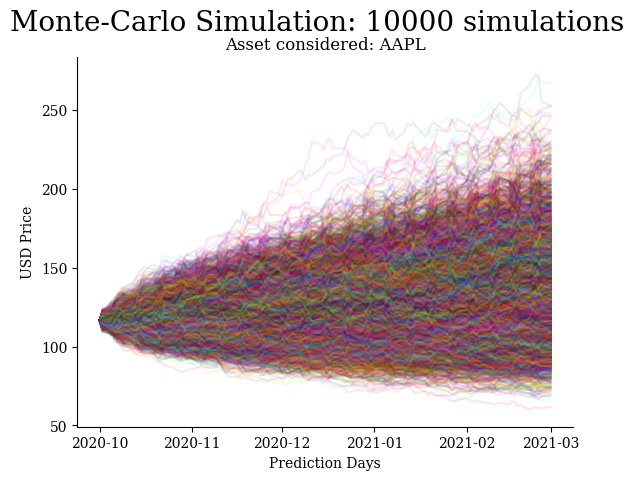

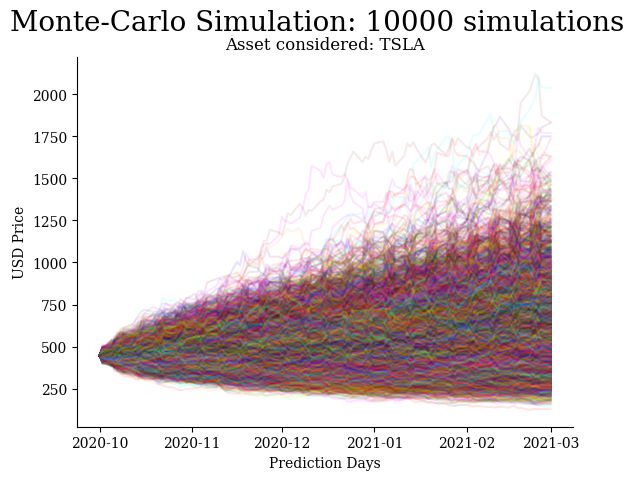

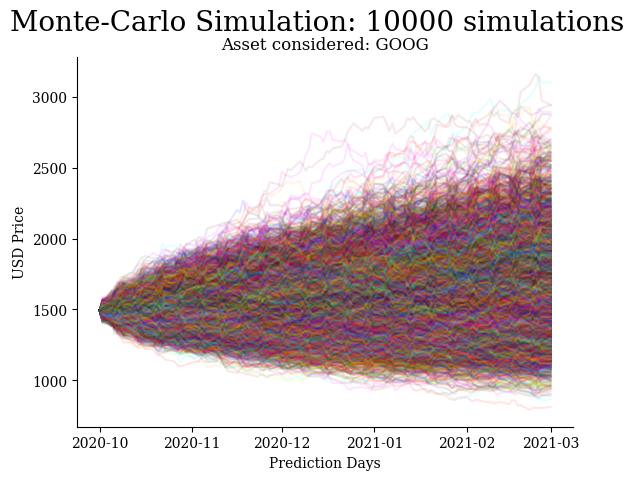

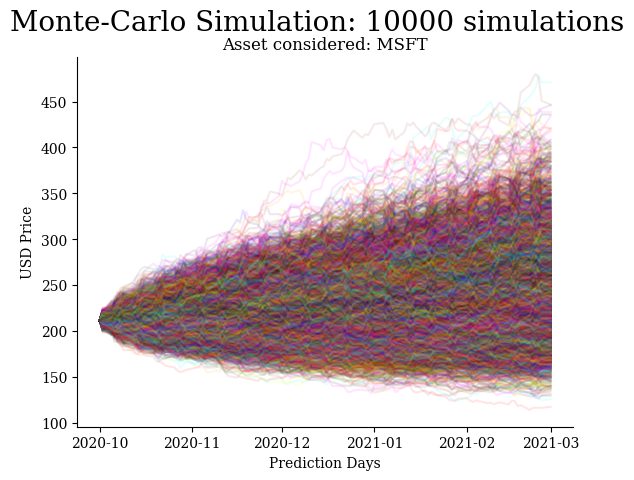

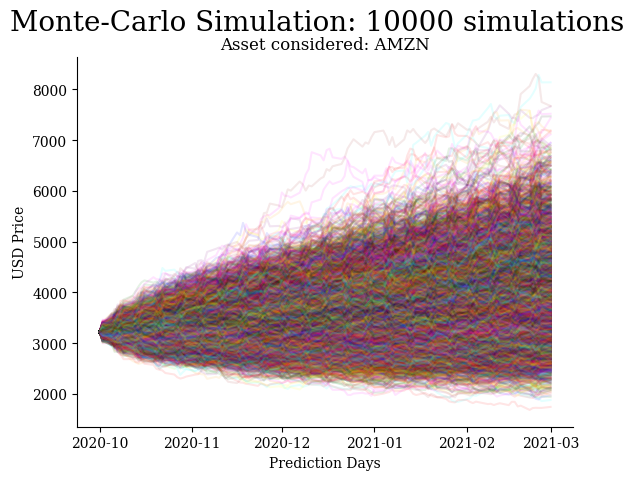

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Uncomment if running in Jupyter Notebook
# %matplotlib inline

# File paths for the database and output directories for predictions and metrics
database_location = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/Database/"
output_location_predictions = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/"
output_location_metrics = "/mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/"

# Ensure directories exist
os.makedirs(output_location_predictions, exist_ok=True)
os.makedirs(output_location_metrics, exist_ok=True)

# Dictionary of stock files to be processed
stock_files = {
    "AAPL": "Pre_Processed_AAPL.csv",
    "TSLA": "Pre_Processed_TSLA.csv",
    "GOOG": "Pre_Processed_GOOG.csv",
    "MSFT": "Pre_Processed_MSFT.csv",
    "AMZN": "Pre_Processed_AMZN.csv"
}

# Function to load stock data, compute daily returns, and split data into training and test sets
def load_stock_data(stock_name, file_path, start_date, end_date, pred_end_date):
    stock_data = pd.read_csv(file_path)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    
    train_set = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)].set_index('Date')['Adj. Close']
    test_set = stock_data[(stock_data['Date'] >= '2020-10-01') & (stock_data['Date'] <= pred_end_date)].set_index('Date')['Adj. Close']
    daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
    return train_set, test_set, daily_returns

# Function to run Monte Carlo simulation based on Geometric Brownian Motion (GBM)
def run_monte_carlo_simulation(train_set, daily_returns, test_set, scen_size=10000, pred_end_date='2021-02-26'):
    So = train_set.iloc[-1]
    dt = 1
    
    n_of_wkdays = pd.date_range(start=train_set.index[-1], end=pred_end_date, freq='B').size
    T = n_of_wkdays
    N = int(T / dt)
    t = np.arange(1, N + 1)
    
    mu = np.mean(daily_returns)
    sigma = np.std(daily_returns)
    
    np.random.seed(42)
    b = {str(scen): np.random.normal(0, 1, N) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
    
    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
    
    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))
    
    S_max = [S[:, i].max() for i in range(0, N + 1)]
    S_min = [S[:, i].min() for i in range(0, N + 1)]
    S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
    
    min_length = min(len(S_pred[1:]), len(test_set.index))
    S_pred = S_pred[1:min_length + 1]
    
    final_df = pd.DataFrame(data={'Date': test_set.index[:min_length], 'Actual_Adj_Close': test_set.values[:min_length], 'Predicted_Adj_Close': S_pred})
    final_df.set_index('Date', inplace=True)
    
    return final_df, S

# Function to plot the Monte Carlo simulation paths
def plot_simulations(stock_name, S, train_set, test_set, scen_size):
    plt.rcParams["font.family"] = "serif"
    fig, ax = plt.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.suptitle(f'Monte-Carlo Simulation: {scen_size} simulations', fontsize=20)
    plt.title(f'Asset considered: {stock_name}')
    plt.ylabel('USD Price')
    plt.xlabel('Prediction Days')

    # Generate date range and plot each simulation if valid data is available
    date_range = pd.date_range(start=train_set.index[-1], periods=S.shape[1], freq='B')
    if S.shape[0] > 0 and S.shape[1] > 0:
        for i in range(scen_size):
            color = np.random.choice(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown'])
            plt.plot(date_range, S[i, :], color=color, alpha=0.1)
    else:
        print(f"Warning: S array has invalid shape {S.shape}. No data to plot.")

    plt.show()

# Run Monte Carlo simulation for each stock
def run_monte_carlo_for_stock(stock_name, file_path, start_date, end_date, pred_end_date, scen_size=10000):
    train_set, test_set, daily_returns = load_stock_data(stock_name, file_path, start_date, end_date, pred_end_date)
    final_df, S = run_monte_carlo_simulation(train_set, daily_returns, test_set, scen_size, pred_end_date)

    # Plot the Monte Carlo simulation results
    plot_simulations(stock_name, S, train_set, test_set, scen_size)

# Loop through each stock in the stock_files dictionary and run the simulation
for stock, file in stock_files.items():
    file_path = database_location + file
    run_monte_carlo_for_stock(stock, file_path, start_date='2015-01-02', end_date='2020-10-01', pred_end_date='2021-02-26')

Predictions saved for AAPL in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-A/AAPL_predictions.csv
Metrics saved for AAPL in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-A/AAPL_metrics.csv


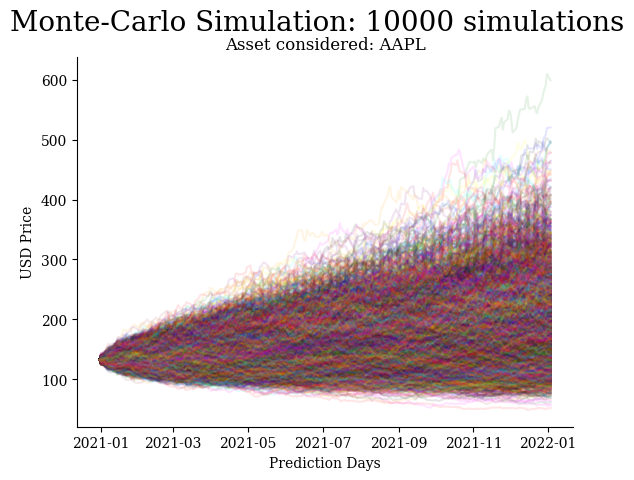

Predictions saved for TSLA in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-A/TSLA_predictions.csv
Metrics saved for TSLA in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-A/TSLA_metrics.csv


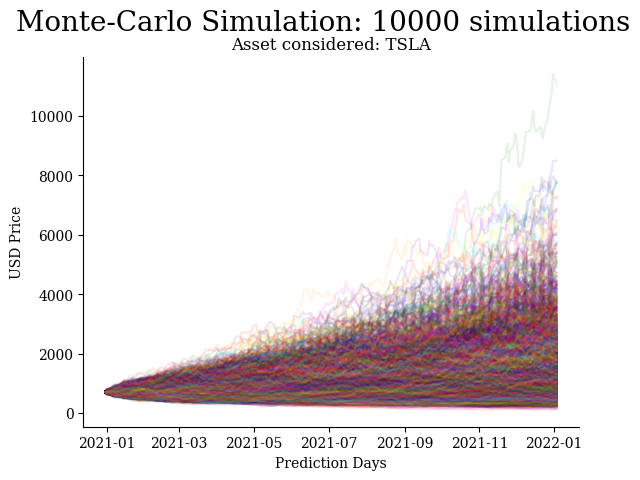

Predictions saved for GOOG in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-A/GOOG_predictions.csv
Metrics saved for GOOG in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-A/GOOG_metrics.csv


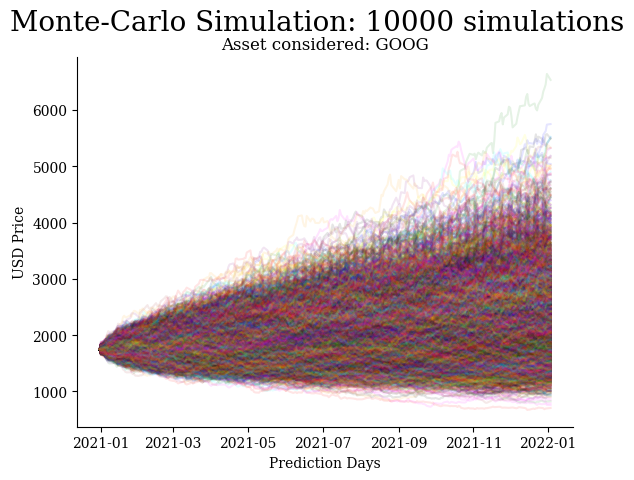

Predictions saved for MSFT in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-A/MSFT_predictions.csv
Metrics saved for MSFT in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-A/MSFT_metrics.csv


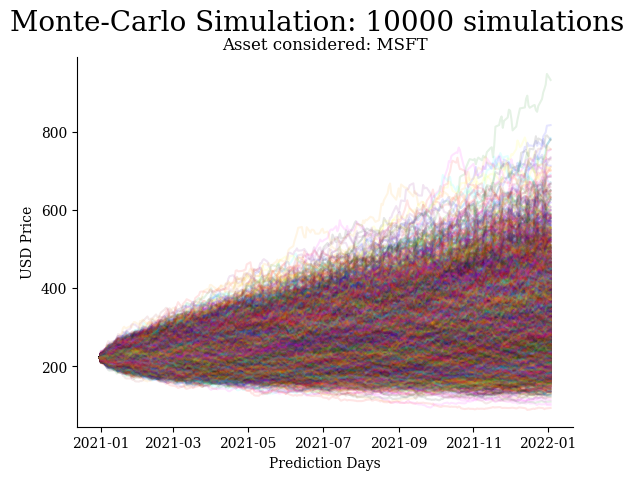

Predictions saved for AMZN in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-A/AMZN_predictions.csv
Metrics saved for AMZN in Dataset-A: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-A/AMZN_metrics.csv


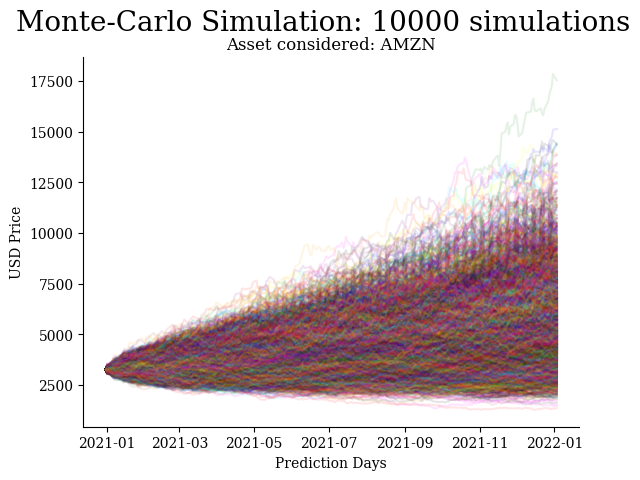

Predictions saved for AAPL in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-B/AAPL_predictions.csv
Metrics saved for AAPL in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-B/AAPL_metrics.csv


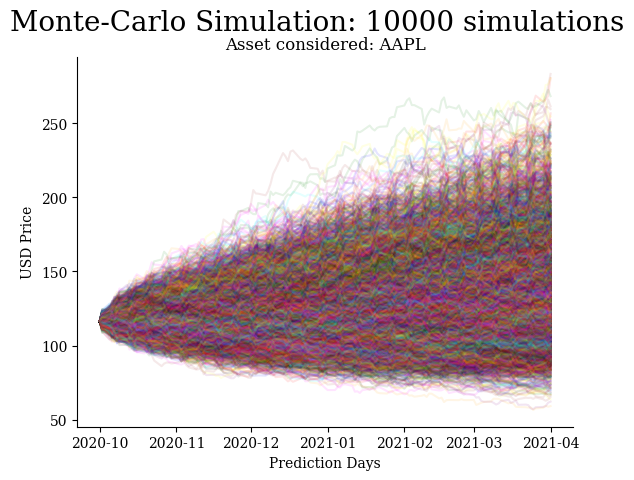

Predictions saved for TSLA in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-B/TSLA_predictions.csv
Metrics saved for TSLA in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-B/TSLA_metrics.csv


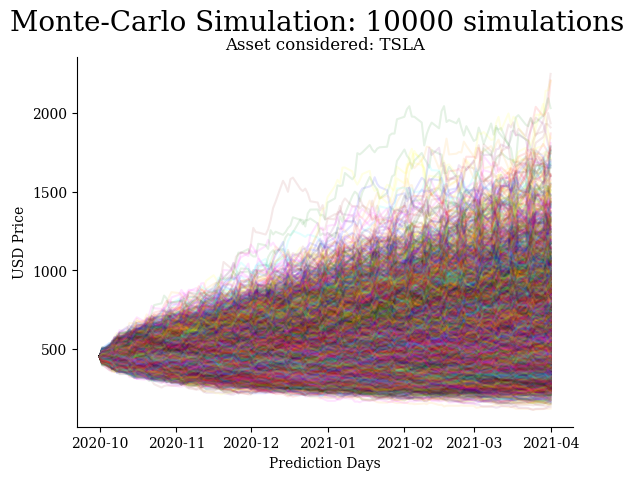

Predictions saved for GOOG in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-B/GOOG_predictions.csv
Metrics saved for GOOG in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-B/GOOG_metrics.csv


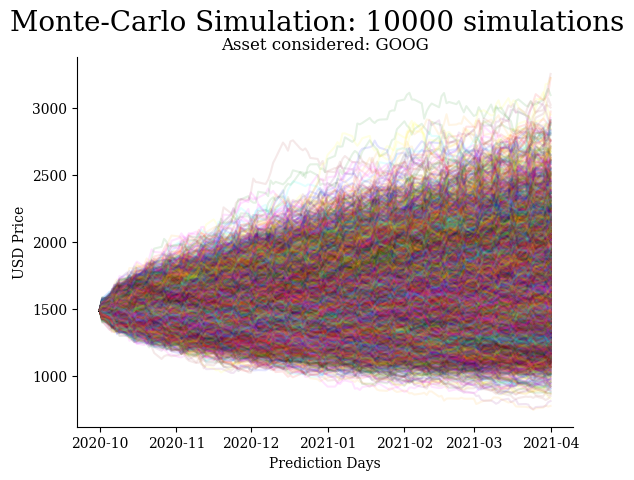

Predictions saved for MSFT in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-B/MSFT_predictions.csv
Metrics saved for MSFT in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-B/MSFT_metrics.csv


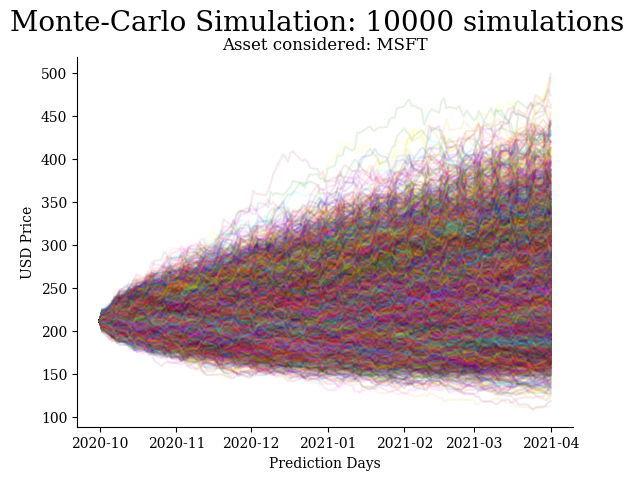

Predictions saved for AMZN in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/predictions/Dataset-B/AMZN_predictions.csv
Metrics saved for AMZN in Dataset-B: /mnt/External/8TBHDD/Keyur/Stock-Price-Prediction/MonteCarlo/metrics/Dataset-B/AMZN_metrics.csv


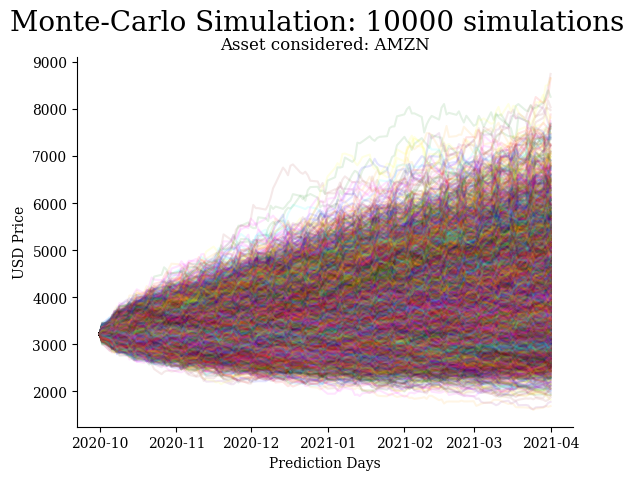

In [5]:
# Dictionary of datasets with time periods
datasets = {
    "Dataset-A": {
        "start_date": "2015-01-02",
        "end_date": "2020-12-31",
        "pred_end_date": "2021-12-31"
    },
    "Dataset-B": {
        "start_date": "2015-01-02",
        "end_date": "2020-10-01",
        "pred_end_date": "2021-03-31"
    }
}

# Function to run Monte Carlo simulation for a specific dataset period
def run_monte_carlo_for_dataset(stock_name, file_path, dataset_name, start_date, end_date, pred_end_date, scen_size=10000):
    # Create output directories for the dataset
    dataset_predictions_dir = os.path.join(output_location_predictions, dataset_name)
    dataset_metrics_dir = os.path.join(output_location_metrics, dataset_name)
    os.makedirs(dataset_predictions_dir, exist_ok=True)
    os.makedirs(dataset_metrics_dir, exist_ok=True)
    
    # Run Monte Carlo simulation
    train_set, test_set, daily_returns = load_stock_data(stock_name, file_path, start_date, end_date, pred_end_date)
    final_df, S = run_monte_carlo_simulation(train_set, daily_returns, test_set, scen_size, pred_end_date)
    
    # Save predictions to a CSV file
    predictions_file = os.path.join(dataset_predictions_dir, f"{stock_name}_predictions.csv")
    final_df.to_csv(predictions_file)
    print(f"Predictions saved for {stock_name} in {dataset_name}: {predictions_file}")
    
    # Calculate metrics and save
    mse = mean_squared_error(final_df['Actual_Adj_Close'], final_df['Predicted_Adj_Close'])
    mae = mean_absolute_error(final_df['Actual_Adj_Close'], final_df['Predicted_Adj_Close'])
    rmse = math.sqrt(mse)
    metrics = pd.DataFrame({
        'Metric': ['MSE', 'MAE', 'RMSE'],
        'Value': [mse, mae, rmse]
    })
    metrics_file = os.path.join(dataset_metrics_dir, f"{stock_name}_metrics.csv")
    metrics.to_csv(metrics_file, index=False)
    print(f"Metrics saved for {stock_name} in {dataset_name}: {metrics_file}")
    
    # Plot and save simulations
    plot_simulations(stock_name, S, train_set, test_set, scen_size)

# Loop through datasets and stocks
for dataset_name, period in datasets.items():
    for stock, file in stock_files.items():
        file_path = database_location + file
        run_monte_carlo_for_dataset(
            stock_name=stock,
            file_path=file_path,
            dataset_name=dataset_name,
            start_date=period['start_date'],
            end_date=period['end_date'],
            pred_end_date=period['pred_end_date'],
            scen_size=10000
        )